# Цифровая обработка сигналов - Лекция 12
# Тема: Фильтры Фарроу

## Введение

Перед вами обучающий материал по основам **цифровой обработки сигналов** с использованием средств языка программирования Python. Предполагается, что читатель имеет базовые знания из области высшей математики, а также владеет языком Python и хотя бы поверхностно знает различные python-библиотеки - numpy/scipy, matplotlib и другие. 

Для пользователей MATLAB / GNU Octave освоение материала с точки зрения программного кода не составит труда, поскольку основные функции и их атрибуты во многом идентичны и схожи с методами из python-библиотек.

## Теоретический базис

Из предыдущих разделов мы помним, что для более эффективной обработки сигналов используется понижение или увеличение частоты дискретизации. Иногда есть потребность в нецелочисленном преобразовании частоты дискретизации, например, когда две системы с разной частотой дискретизации должны быть соединены. Подобное очень распространено в телекоммуникациях, мультимедиа, цифровом аудио и т.д. 

Изменение частоты дискретизации на дробный коэффициент $\frac{L}{M}$, где $L$ и $M$ — целые числа, иногда называется дробным изменением частоты дискретизации или повторной дискретизацией, так как оно может быть достигнуто поэтапно - увеличением частоты дискретизации на $L$, а затем уменьшением на $M$. 

Также может потребоваться получить преобразованный сигнал с задержкой на какой-либо период. Передискретизировать входной сигнал с дробной задержкой позволяют фильтры с дробной задержкой (Fractional Delay Filters - FDF). Такие фильтры часто используются для цифровой обработки сигналов в таких задачах, как кодирование и синтез речи.

Для решения указанных задач можно использовать один из эффективных методов на основе полимиальной Лагранжевой интерполяции. Особое внимание будет уделено фильтру Фарроу, эффективно реализующему метод полиномиальной Лагранжевой интерполяции для цифровой передискретизации сигналов.


### Постановка задачи
Пусть имеется входной сигнал $s(n)$, $n = 0, 1, 2 \ldots$, с частотой дискретизации $F_s$. Мы хотим передискретизировать $s(n)$ с некоторой задержкой и получить выходной сигнал $y(k)$, $k = 0, 1, 2 \ldots$, с частотой дискретизации $F_y$.

Иными словами, передискретизировать сигнал значит произвести ресэмплинг - получить значения сигнала $y(k)$, пересчитав значения входного сигнала $s(n)$, взятые с частотой дискретизации $F_y = \frac{L}{M} F_s$, где $L$ и $M$ целые числа. При ненулевой задержке, первый отсчет $y(0)$ будет задержан во времени относительно первого отсчета входного сигнала $s(0)$ на величину $\Delta t = \frac{d}{F_s}$, $-1 \leq d < 0$.

Отсчет входного сигнала $s(n)$ с номером $n$ соответствует моменту времени $t_n = \frac{n}{F_s}$. Для перехода к отсчетам выходного сигнала $y(k)$ с номером $k$, следует сперва произвести передискретизацию ($k \frac{M}{L} \frac{t_n}{n}$), и сдвинуть сигнал на величину задержки $\Delta t$:
$$t_k = k \frac{M}{L F_s} - \frac{d}{F_s} \tag{12.1}$$

Для простоты, пусть $F_s = 1$, тогда с учетом (12.1) отсчет выходного сигнала $x_k$ можно записать так:
$$x_k = t_k F_s = k \frac{M}{L} - d \tag{12.2}$$

Получив значения $x_k$, можно рассчитать дискретные значения непрерывного сигнала $s(t)$ для моментов времени $s(x_k)$. В итоге получим передискретизированный дискретный сигнал $s(n)$.

На рисунке 1 можно проанализировать как изменятся моменты взятия отсчетов при переходе от входного сигнала $s(n)$ к выходному $y(k)$ при различных значениях $L$, $M$ и $d$

<img src="https://raw.githubusercontent.com/karinakvanchiani/dsp-theory/kvanchiani/farrow/img/farrow_res.svg" alt="Farrow resampling" style="width: 90%;"/>

*Рис. 1. Соотношения моментов взятия отсчетов сигналов $s(n)$ (красным) и $y(k)$ (синим), при различных значениях $L$, $M$ и $d$. (вариант 1) Частота дискретизации $y(k)$ равна частоте дискретизации $s(n)$ и, так как задержка равна 0, сигналы полностью совпадут. (вариант 2) Выходной сигнал $y(k)$ будет задержан на величину $d$ относительно входного сигнала $s(n)$. (вариант 3) Частота дискретизации $y(k)$ в 5 раз выше частоты дискретизации $s(n)$ - значений будет в 5 раз больше. (вариант 4) В данном случае сигнал $y(k)$ получился не только посредством передискретизации $s(n)$, но и с задержкой 0.2.* 

На рисунке 2 изображен процесс передискретизации для 2го варианта (компенсация дробной задержки).

<img src="https://raw.githubusercontent.com/karinakvanchiani/dsp-theory/kvanchiani/farrow/img/farrow_res_signal.svg" alt="Farrow resampling signal" style="width: 50%;"/>

*Рис. 2. Входной сигнал (вверху) задержан на $d$ для получения выходного сигнала (внизу).*

___
## Resampling

**Программная реализация передискретизации сигнала в частных случаях**.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def resampling(d: float, l: int, m: int, num: int, fs: int = 1, n: int = 15):
    """
    Signal resampling and visualization

    Parameters
    ----------
    d : float
        Delay value
    l : int
        Fractional coefficient numerator
    m : int
        Fractional coefficient denominator
    num : int
        Graph number
    fs : int
        Input signal frequency
    n: int
        Number of points for signal (same as period)
    """
    coef = l / m
    fy = fs / coef

    xs = np.arange(1, n, fs)
    s = np.exp(np.cos(xs))

    xy = np.arange(1, n, fy) - d
    y = np.exp(np.cos(xy))
    
    plt.subplot(5, 1, num)
    fy_text = f'Fy = {round(coef, 2)} * Fs' if coef != 1 else 'Fy = Fs'
    plt.title(f'Case {num}: x0 = {d}, {fy_text}')
    plt.stem(xy, y, 'g', markerfmt='go', label='y')
    plt.stem(xs, s, 'b', markerfmt='bo', label='s')
    plt.xlim([1, n - 1])
    plt.legend()
    plt.grid()

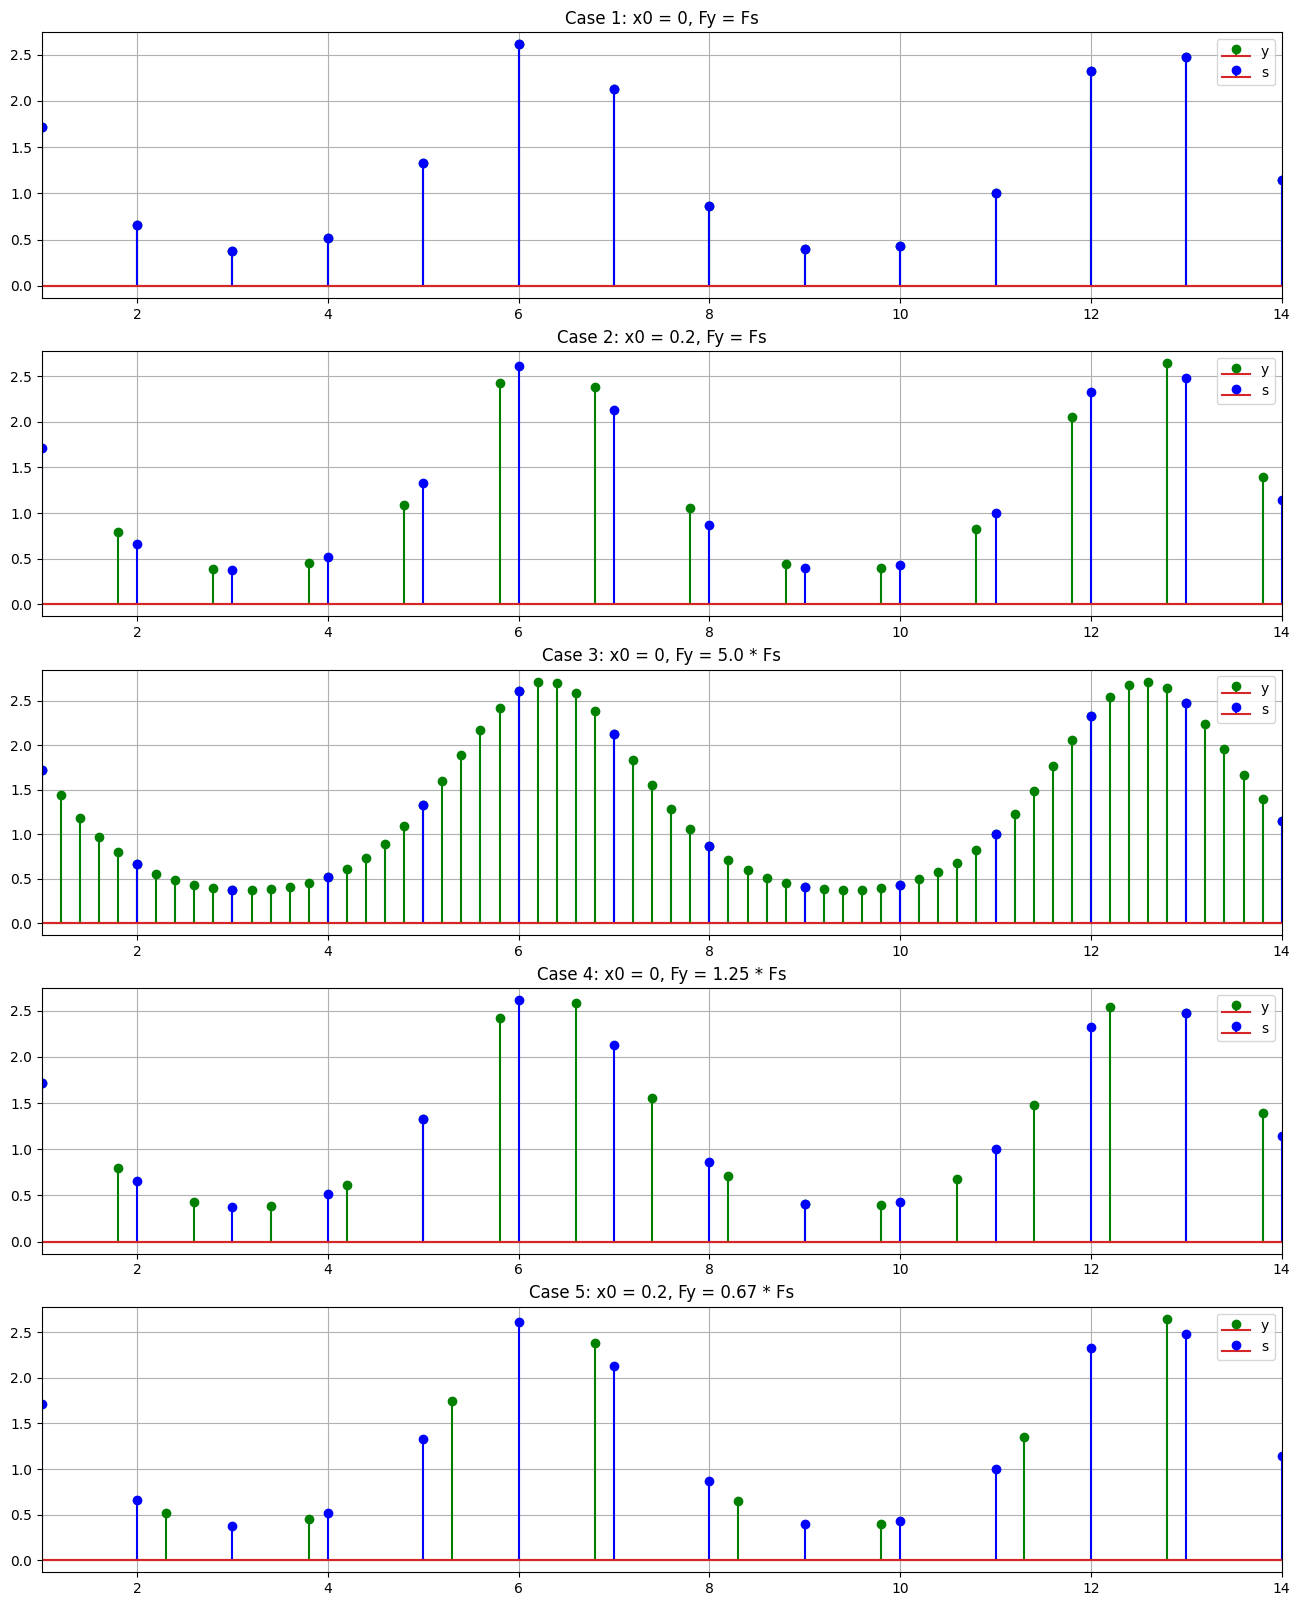

In [3]:
fig = plt.figure(figsize=(16, 20), dpi=100)

resampling(d=0, l=1, m=1, num=1)
resampling(d=0.2, l=1, m=1, num=2)
resampling(d=0, l=5, m=1, num=3)
resampling(d=0, l=5, m=4, num=4)
resampling(d=0.2, l=2, m=3, num=5)

## Интерполяционный полином Лагранжа

Одним из самых интересных подходов к передискретизации, ввиду простоты и эффективности, считается класс интерполяционных фильтров. Рассмотрим один из таких подходов, связанный с полиномом Лагранжа. Полиномиальная интерполяция Лагранжа используется для увеличения частоты дискретизации и повторного заполнения пробелов между звуковыми сигналами, что помогает предсказать точный звук. Метод интерполяции Лагранжа имеет положительную особенность - он точен на низких частотах (большинство сигналов являются низкочастными).

Из математики известно, что через любые $N$ точек проходит единственный полином степени $N - 1$ (этот единственный полином и есть полином Лагранжа):

$$y(k) = a_0 + a_1 \cdot t + a_2 \cdot t^2 + \ldots + a_n \cdot t^n$$

где $a_n$ — коэффициенты полинома, которые рассчитываются на основе дискретных значений $s(n)$, $n = 0 \ldots N-1$.

### Решение системы уравнений через его представление в матричной форме

Значения полинома $a_n$ можно найти, решив систему уравнений:

$$\begin{equation*} 
\begin{cases} 
a_0 + a_1 \cdot 0 + a_2 \cdot 0^2 + \ldots + a_{N-1} \cdot 0^{N-1} = s(0), \\ a_0 + a_1 \cdot 1 + a_2 \cdot 1^2 + \ldots + a_{N-1} \cdot 1^{N-1} = s(1), \\ a_0 + a_1 \cdot 2 + a_2 \cdot 2^2 + \ldots + a_{N-1} \cdot 2^{N-1} = s(2), \\ \vdots \\ a_0 + a_1 \cdot (N-1) + a_2 \cdot (N-1)^2 + \ldots + a_{N-1} \cdot (N-1)^{N-1} = s(N-1). 
\end{cases} 
\end{equation*} \tag{12.3}$$

представив ее в матричной форме:
$$\begin{equation*} \mathbf{M \cdot a = s}, \end{equation*} \tag{12.4}$$
где
$$\begin{equation*} 
\begin{array} & \mathbf{M} = \left[ \begin{array}{ccccc} 1 & 0 & 0^2 & \ldots & 0^{N-1}\\ 1 & 1 & 1^2 & \ldots & 1^{N-1}\\ 1 & 2 & 2^2 & \ldots & 2^{N-1}\\ \vdots& \vdots & \vdots &\ddots & \vdots\\ 1 & N-1 & (N-1)^2 &\ldots & (N-1)^{N-1} \end{array} \right], & \mathbf{a} = \left[ \begin{array}{ccccc} a_0 \\ a_1 \\ a_2 \\ \vdots \\ a_{N-1} \end{array} \right], & \mathbf{s} = \left[ \begin{array}{ccccc} s(0) \\ s(1) \\ s(2) \\ \vdots \\ s(N-1) \end{array} \right]. \end{array}
\end{equation*} \tag{12.5}$$

Решение системы уравнений может быть получено в виде:
$$\begin{equation*} \mathbf{a = M^{-1} \cdot s}, \end{equation*} \tag{12.6}$$
где $\mathbf{M^{-1}}$ — обратная матрица для матрицы $\mathbf{M}$.

Однако подобный метод неэффективен, ввиду необходимости в обращении матрицы, что является очень затратной процедурой с точки зрения вычислительных ресурсов.

### Использование полиномиальной интерполяции для цифровой передискретизации сигналов

Главная особенность интерполяционных фильтров состоит в том, что они могут быть эффективно реализованы с использованием структуры Фарроу. Теперь для решения уравнения воспользуемся более эффективной реализацией полиномиального интерполятора Лагранжа - реализацию Фарроу.

Так как интерполяция многочленом Лагранжа больших потоков данных неоптимальна, для вычислений поток данных можно разбить на части, на каждом из которых приближенно заменить функцию многочленом не слишком большой степени. Такой подход называется кусочно-полиномиальной (или локальной) интерполяцией. Одним из наиболее популярных видов этого подхода считается метод, в котором по 4м точкам строится кубический интерполятор Лагранжа, называемый [кубическим сплайном](https://ru.wikipedia.org/wiki/%D0%9A%D1%83%D0%B1%D0%B8%D1%87%D0%B5%D1%81%D0%BA%D0%B8%D0%B9_%D1%81%D0%BF%D0%BB%D0%B0%D0%B9%D0%BD). Значения построенного сплайна берутся в качестве интерполирующей функции на центральном интервале, который задается второй и третьей точками. Для 1го (или 2х) соседних интервалов строится свой подобный полином по 4м точкам и так далее. В методе Фарроу используется интервал $[-2, 1]$, при котором система линейных уравнений примет следующий вид:

$$\begin{equation*} 
\begin{cases} 
a_0 + a_1 \cdot (-2) + a_2 \cdot (-2)^2 + a_3 \cdot (-2)^3 = s(-2), \\ a_0 + a_1 \cdot (-1) + a_2 \cdot (-1)^2 + a_3 \cdot (-1)^3 = s(-1), \\ a_0 + a_1 \cdot 0 + a_2 \cdot 0^2 + a_3 \cdot 0^3 = s(0), \\ a_0 + a_1 \cdot 1 + a_2 \cdot 1^2 + a_3 \cdot 1^3 = s(1). 
\end{cases} 
\end{equation*} \tag{12.7}$$

Так как полином третьей степени строится по 4м точкам, для каждого $x_k$ необходимо найти по 2 отсчета правее и левее $x_k$. Другими словами, с помощью 4х входных отсчетов $s(1)$, $s(0)$, $s(-1)$ и $s(-2)$ можно найти значение $y(k)$.

Находим коэффициенты $a_n$:
$$\begin{equation*} 
\begin{cases} 
a_0 = s(0),\\ 
a_1 = \frac{1}{6} \cdot s(-2) - s(-1) + \frac{1}{2} \cdot s(0) + \frac{1}{3} \cdot s(1),\\ 
a_2 = \frac{1}{2} \cdot s(-1) - s(0) + \frac{1}{2} \cdot s(1),\\ 
a_3 = -\frac{1}{6} \cdot s(-2) + \frac{1}{2} \cdot s(-1) - \frac{1}{2} \cdot s(0) + \frac{1}{6} \cdot s(1).\\ 
\end{cases} 
\end{equation*} \tag{12.8}$$

Уравнения для рассчета коэффициентов кубического интерполятора можно представить параллельным соединением 3-х [КИХ-фильтров](https://github.com/hukenovs/dsp-theory/blob/master/src/dsp_theory_6_iir_fir_filters.ipynb) 3-го порядка (что делает его очень подходящим для реализации на платформах FPGA), каждый из которых рассчитывает один из коэффициентов. Основное преимущество такого подхода заключается в том, что коэффициента фильтрации не меняются, меняется только $delta_k$ - расстояние между $x_k$ и ближайшим отсчетом входного сигнала. Поэтому, зная коэффициенты и $delta_k$ для каждого отсчета, можно найти приближенные значения выходного сигнала $y(k)$. На рисунке 3 представлена структура фильтра Фарроу. 

<img src="https://raw.githubusercontent.com/karinakvanchiani/dsp-theory/kvanchiani/farrow/img/farrow.svg" alt="Farrow filter" style="width: 90%;"/>

*Рис. 3. Структура фильтра Фарроу для цифровой передискретизации сигналов на основе полиномиальной Лагранжевой интерполяции.*

___
## Farrow Resampling

**Программная реализация передискретизации сигнала с помощью фильтра Фарроу**.

In [4]:
from tabulate import tabulate

In [5]:
def get_output_signal(d: float, s: np.ndarray, l: int, m: int, len_y: int):
    """
    Get resampled signal

    Parameters
    ----------
    d : float
        Delay value
    s:  numpy.ndarray
        Expanded input signal 
    l : int
        Fractional coefficient numerator
    m : int
        Fractional coefficient denominator
    len_y : int
        Output signal length
    """
    coef = l / m
    
    xy, y, strings = [], [], []
    for k in range(len_y):
        x_k = k / coef - d
        delta_k = np.floor(x_k) + 1 - x_k
        n = int(np.floor(x_k) + 2) + 2
        
        a0 = s[n - 1]
        a1 = 1 / 6 * s[n - 3] - s[n - 2] + 0.5 * s[n - 1] + 1 / 3 * s[n]
        a2 = 0.5 * s[n - 2] - s[n - 1] + 0.5 * s[n]
        a3 = -1 / 6 * s[n - 3] + 0.5 * s[n - 2] - 0.5 * s[n - 1] + 1 / 6 * s[n]

        y.append(a0 - a1 * delta_k + a2 * delta_k**2 - a3 * delta_k**3)
        xy.append(x_k)
        strings.append([k, n - 2, x_k, delta_k, s[n - 3], s[n - 2], s[n - 1], s[n], y[-1]])
    return xy, y, strings 

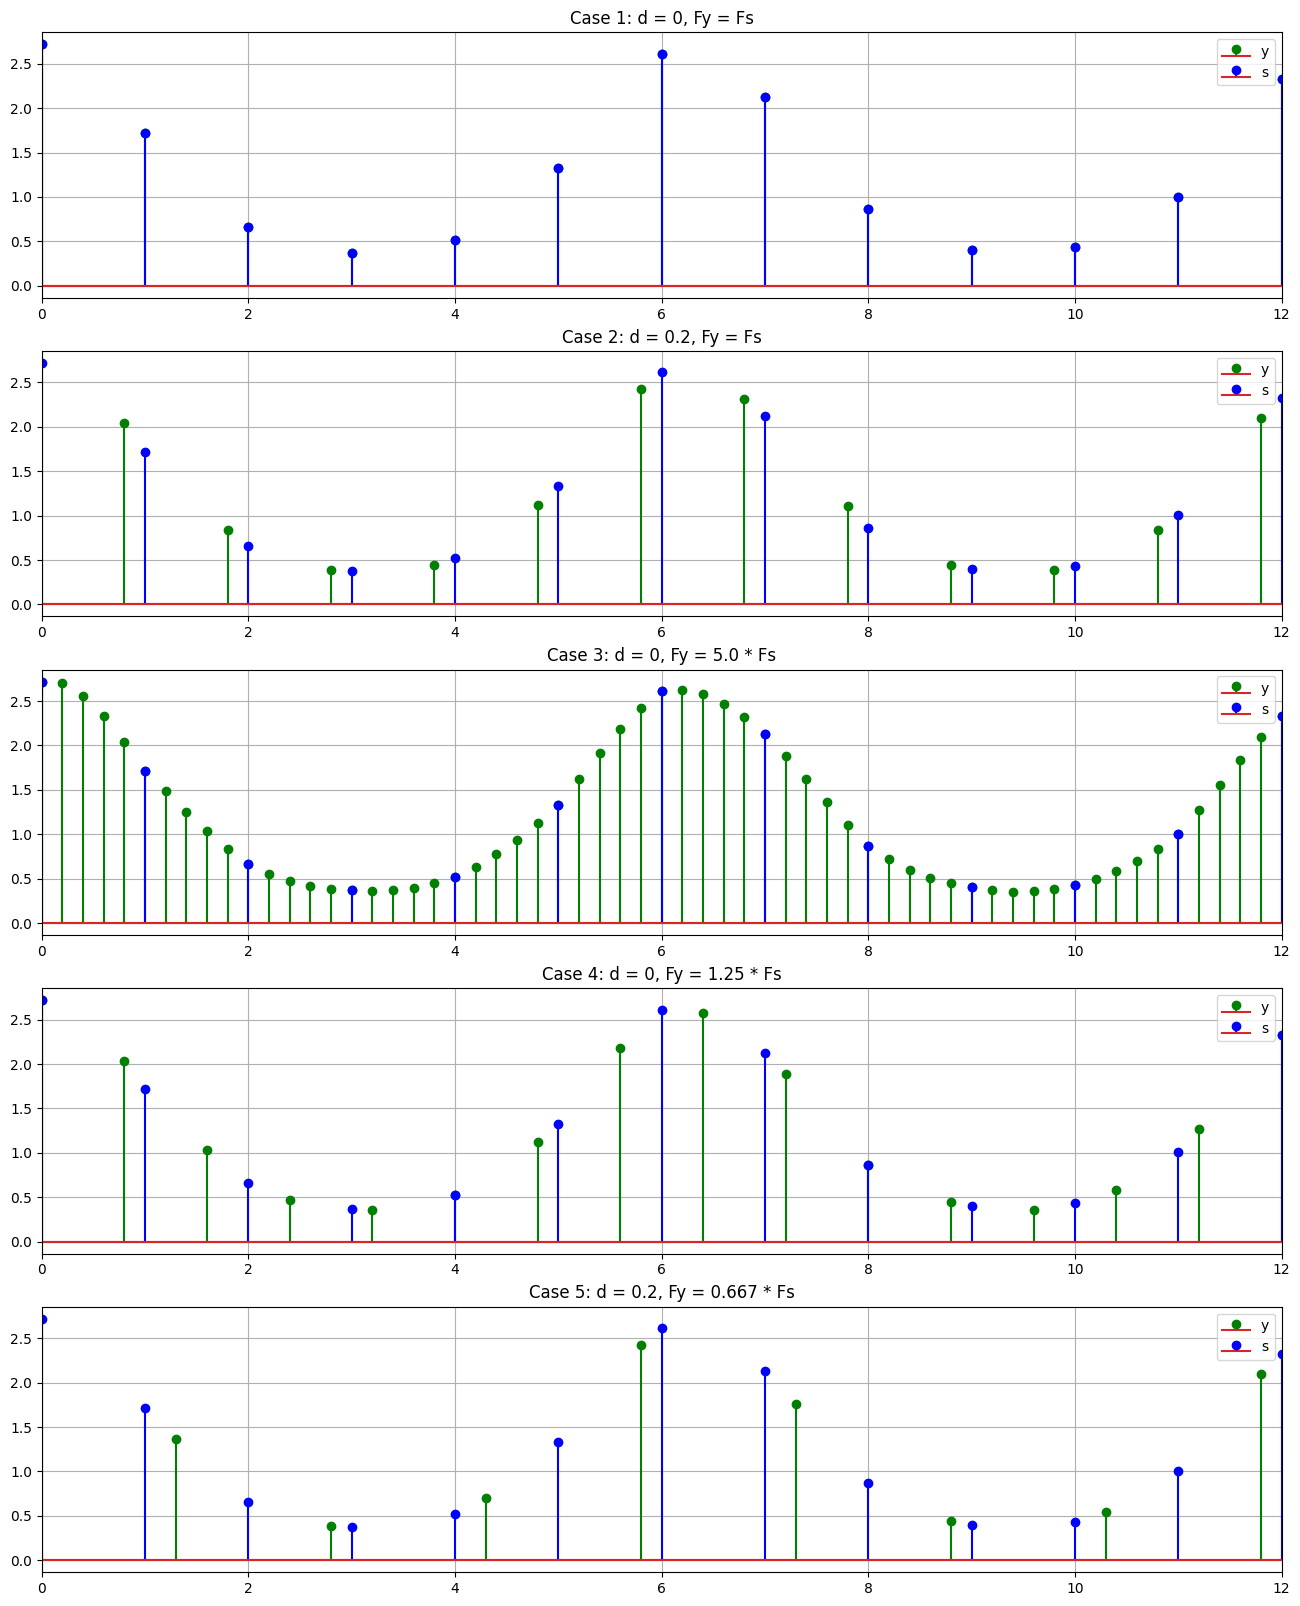

In [6]:
def farrow_resample(d: float, l: int, m: int, num: int, fs: int = 1, n: int = 15, get_strings: bool = False):
    """
    Farrow signal resampling  and visualization

    Parameters
    ----------
    d : float
        Delay value
    l : int
        Fractional coefficient numerator
    m : int
        Fractional coefficient denominator
    num : int
        Graph number
    fs : int
        Input sygnal frequency
    n: int
        Number of points for signal (same as period)
    get_strings: bool
        Information recieve flag
    """
    coef = l / m

    xs = np.arange(0, n, fs)
    s = np.exp(np.cos(xs))
    s_expanded = np.concatenate((np.array([0., 0.]), s, np.array([0., 0.])))
    
    len_y = int(np.floor(len(s) * coef))
    xy, y, strings = get_output_signal(d, s_expanded, l, m, len_y)
    
    if get_strings:
        return strings
    
    plt.subplot(5, 1, num)
    fy_text = f'Fy = {round(coef, 3)} * Fs' if coef != 1 else 'Fy = Fs'
    plt.title(f'Case {num}: d = {d}, {fy_text}')
    plt.stem(xy, y, 'g', markerfmt='go', label='y')
    plt.stem(xs, s, 'b', markerfmt='bo', label='s')
    plt.xlim([0, 12])
    plt.legend()
    plt.grid()

fig = plt.figure(figsize=(16, 20), dpi=100)

farrow_resample(d=0, l=1, m=1, num=1)
farrow_resample(d=0.2, l=1, m=1, num=2)
farrow_resample(d=0, l=5, m=1, num=3)
farrow_resample(d=0, l=5, m=4, num=4)
farrow_resample(d=0.2, l=2, m=3, num=5)

На таблице ниже представлен процесс передискретизации входного сигнала с коэффициентами: $L = 2$, $M = 3$ и $d = 0.2$.

In [7]:
strings = farrow_resample(d=0.2, l=2, m=3, num=0, get_strings=True)
col_names = ['k', 'n', 'x_k', 'delta_k', 's(n - 3)', 's(n - 2)', 's(n - 1)', 's(n)', 'y(k)']
print(tabulate(strings, headers=col_names, tablefmt='fancy_grid'))

╒═════╤═════╤═══════╤═══════════╤════════════╤════════════╤════════════╤══════════╤══════════╕
│   k │   n │   x_k │   delta_k │   s(n - 3) │   s(n - 2) │   s(n - 1) │     s(n) │     y(k) │
╞═════╪═════╪═══════╪═══════════╪════════════╪════════════╪════════════╪══════════╪══════════╡
│   0 │   1 │  -0.2 │       0.2 │   0        │   0        │   2.71828  │ 1.71653  │ 2.2662   │
├─────┼─────┼───────┼───────────┼────────────┼────────────┼────────────┼──────────┼──────────┤
│   1 │   3 │   1.3 │       0.7 │   2.71828  │   1.71653  │   0.659583 │ 0.371579 │ 1.36774  │
├─────┼─────┼───────┼───────────┼────────────┼────────────┼────────────┼──────────┼──────────┤
│   2 │   4 │   2.8 │       0.2 │   1.71653  │   0.659583 │   0.371579 │ 0.520147 │ 0.383619 │
├─────┼─────┼───────┼───────────┼────────────┼────────────┼────────────┼──────────┼──────────┤
│   3 │   6 │   4.3 │       0.7 │   0.371579 │   0.520147 │   1.32798  │ 2.61214  │ 0.701599 │
├─────┼─────┼───────┼───────────┼────────────┼────

Так как фильтр Фарроу содержит в себе равные по модулю коэффициенты $\frac{1}{2}$, $\frac{1}{3}$ и $\frac{1}{6}$, мы можем сократить количество умножений. Для этого выражение 12.8 перепишем следующим образом:
$$\begin{equation*} 
\begin{cases} 
a_0 = s(0),\\ 
a_1 = \frac{1}{2} \cdot (s(1) - s(-1)) - a_3,\\ 
a_2 = s(1) - s(0) - a_1 - a_3,\\ 
a_3 = \frac{1}{6} \cdot (s(1) - s(-2)) + \frac{1}{2} \cdot (s(-1) - s(0)).\\ 
\end{cases} 
\end{equation*} \tag{12.9}$$

Таким образом, мы снизили количество умножений - осталось одно на $\frac{1}{6}$ и два тривиальных на $\frac{1}{2}$.